### Criação de modelo para reconhecimento de áudio

#### Objetivo: Acessibilidade

Reconhecimento de comandos de áudio.

[Download do Dataset (2.3 GB)](https://cdn3.gnarususercontent.com.br/3981-tensorflow-keras/Projeto/dataset_commands-002.gz)

Bibliotecas necessárias:

- tensorflow (tensorflow[and-cuda] para rodar com GPU)
- tensorflow-hub
- librosa

In [33]:
import tensorflow as tf
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Domínio do tempo

O **Espectro** nos permite visualizar quais frequências estão presentes e com que intensidade (amplitude).

No domínio do tempo, o sinal de áudio é uma onda contínua que varia com o tempo. No domínio da frequência, o sinal é decomposto em suas componentes de frequência, permitindo-nos ver quais frequências estão presentes e com que amplitude. O resultado dessa transformação é um gráfico onde o eixo horizontal representa as frequências e o eixo vertical representa a amplitude de cada frequência.

Para gerar um espectro de áudio, utilizamos uma técnica matemática chamada **Transformada de Fourier**. Esta técnica transforma um sinal de áudio do domínio do tempo para o domínio da frequência.

### Carregando os dados

Descompactando o arquivo com tar dentro da pasta "dataset".

In [3]:
# !mkdir dataset
# !tar -xzf dataset_commands-002.gz -C dataset

In [4]:
DATA_DIR = Path('dataset')
os.path.exists(DATA_DIR)

True

Adquirindo os caminhos de cada áudio.

In [5]:
audios = []
labels = []

for path in DATA_DIR.iterdir():
    if path.is_dir():
        for audio_path in path.glob('*.wav'):
            audios.append(str(audio_path))
            labels.append(path.stem)

In [6]:
df = pd.DataFrame({
    'audio_paths': audios,
    'labels': labels
})

df.head()

,audio_paths,labels
0,dataset/tree/37fc5d97_nohash_0.wav,tree
1,dataset/tree/e6515415_nohash_1.wav,tree
2,dataset/tree/b0f5b16d_nohash_0.wav,tree
3,dataset/tree/9beccfc8_nohash_0.wav,tree
4,dataset/tree/a0f93943_nohash_0.wav,tree


In [7]:
unique_labels = np.unique(labels)

print(len(unique_labels))
unique_labels

36


array(['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog',
       'down', 'eight', 'five', 'follow', 'forward', 'four', 'go',
       'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off',
       'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three',
       'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero'], dtype='<U18')

Distribuição das categorias dos áudios.

<Axes: xlabel='labels'>

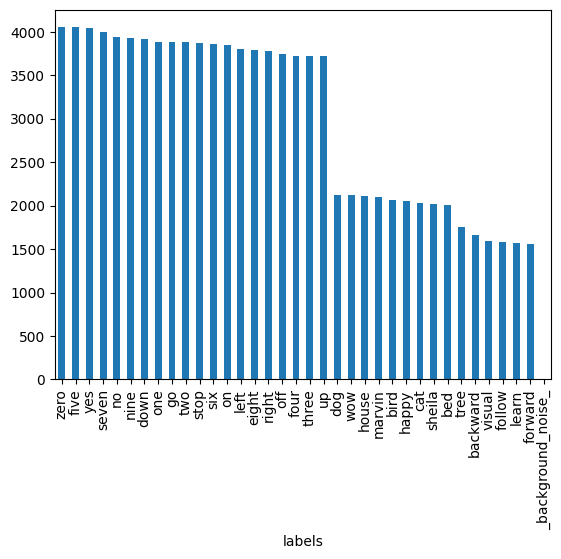

In [8]:
df['labels'].value_counts().plot.bar()

### Visualizando o **Espectro** dos arquivos de áudio

O Espectro faz parte do domínio do tempo.

In [9]:
example_audio_path = str(audios[0]) # Adquirindo o caminho do 1° arquivo de áudio

In [10]:
# Arquivo binário de áudio
audio_binary = tf.io.read_file(example_audio_path)

# Decodificando o arquivo binário de áudio
audio, _ = tf.audio.decode_wav(audio_binary)

# Transformando o áudio em uma sequência de números
audio = tf.squeeze(audio, axis=-1)

I0000 00:00:1746919720.829544     755 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6102 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


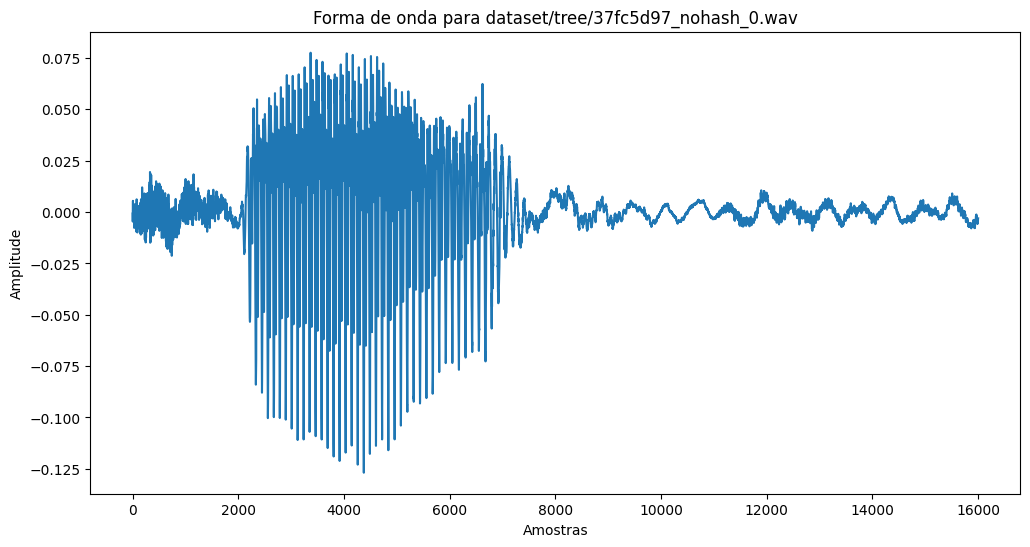

In [11]:
plt.figure(figsize=(12,6))
plt.plot(audio.numpy())
plt.title(f'Forma de onda para {example_audio_path}')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.show()

### Processando os dados de áudio

**Resampling do áudio**

Iremos limitar os arquivos de áudio para apenas 16 mil amostras. Caso houver mais irá cortar o áudio, caso houver menos irá adicionar zeros.

Com a função *resample* da biblioteca SciPy, a frequência de amostragem do áudio é ajustada para 16 kHz caso a frequência original for diferente. Isso garante que todos os arquivos de áudio no conjunto de dados tenham a mesma taxa de amostragem, o que é importante para que a rede neural possa processá-los.

In [12]:
from scipy.signal import resample

In [13]:
def load_and_process_audio(file_path, max_length=16000):
    file_contents = tf.io.read_file(file_path)
    
    # Utilizando o mesmo trecho de código para exibir o espectro
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1) # Espectro
    
    def scipy_resample(wav, sample_rate):
        if sample_rate != 16000:
            wav = resample(wav, int(16000 / sample_rate * len(wav)))
        return wav
    
    wav = tf.py_function(scipy_resample, [wav, sample_rate], tf.float32)
    
    audio_length = tf.shape(wav)[0]
    if audio_length > max_length:
        # Corta o áudio até 16 mil frames
        wav = wav[:max_length]
    else:
        # Adiciona zeros (paddings) no áudio para ter 16 mil frames
        pad_length = max_length - audio_length
        paddings = [[0, pad_length]]
        wav = tf.pad(wav, paddings, 'CONSTANT') # CONSTANT -> Adiciona zeros
    
    return tf.reshape(wav, [max_length])
    
def process_path(file_path, label):
    audio = load_and_process_audio(file_path)
    return audio, label

def paths_and_labels_to_dataset(audio_paths, audio_labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(audio_labels)
    audio_label_ds = tf.data.Dataset.zip((path_ds, label_ds))
    
    return audio_label_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

### Separando os dados

In [14]:
def prepare_for_training(ds, batch_size=32, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # Embaralhamento dos dados
    ds = ds.batch(batch_size) # Separando em batchs (lotes)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE) # Pré carregamento dos dados para a próxima época
    return ds

**Pré processamento das labels**

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

In [16]:
SEED = 5546

X_train, X_val, y_train, y_val = train_test_split(audios, labels_encoded,
                                                  test_size=0.02,
                                                  random_state=SEED,
                                                  stratify=labels_encoded) # Estratificação dos dados (mesma proporção entre as classes para treino e validação)

In [17]:
train_dataset = paths_and_labels_to_dataset(X_train, y_train)
val_dataset = paths_and_labels_to_dataset(X_val, y_val)

Prepara os dados para treinamento (realiza o embaralhamento e separação em lotes).

In [18]:
train_dataset = prepare_for_training(train_dataset)
val_dataset = prepare_for_training(val_dataset)

### Treinando a rede

In [34]:
#from tensorflow.keras import layers, models
from keras import layers, models # Para ter as ajudas de tipo

Nossos dados estão no domínio do tempo, ou seja, as ondas (o espectro) tem uma duração de tempo e é possível ver como a forma de onda evolui ao decorrer do tempo, por isso nosso primeiro modelo se chama *model_time_domain*.

Para a nossa rede neural conseguir extrair características do nosso áudio, podemos utilizar uma camada **convolucional**.

In [20]:
model_time_domain = models.Sequential([
    layers.Input(shape=(16000, 1)),
    
    layers.Conv1D(filters=16,
                  kernel_size=3,
                  activation='relu'), # Nossos dados serão um vetor de uma dimensão, portanto, deverá ser usado o Conv1D
    layers.MaxPooling1D(pool_size=2), # Redução de dimensionalidade
    
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=len(unique_labels), activation='softmax') # Para classificação
])

In [22]:
model_time_domain.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

In [ ]:
history_time_domain = model_time_domain.fit(train_dataset,
                                            epochs=10,
                                            validation_data=val_dataset)

Epoch 1/10


I0000 00:00:1746760450.316073    1343 service.cc:152] XLA service 0x7f79c4005600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746760450.316126    1343 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2025-05-09 00:14:10.352260: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746760450.495646    1343 cuda_dnn.cc:529] Loaded cuDNN version 90501


   4/3242 ━━━━━━━━━━━━━━━━━━━━ 2:24 45ms/step - accuracy: 0.0104 - loss: 3.5987    

I0000 00:00:1746760452.551022    1343 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3242/3242 ━━━━━━━━━━━━━━━━━━━━ 205s 62ms/step - accuracy: 0.1249 - loss: 3.1784 - val_accuracy: 0.2428 - val_loss: 2.6250
Epoch 2/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 146s 45ms/step - accuracy: 0.2881 - loss: 2.4772 - val_accuracy: 0.2801 - val_loss: 2.5274
Epoch 3/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 195s 60ms/step - accuracy: 0.3531 - loss: 2.1970 - val_accuracy: 0.2952 - val_loss: 2.5782
Epoch 4/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 143s 44ms/step - accuracy: 0.4114 - loss: 1.9769 - val_accuracy: 0.2943 - val_loss: 2.6999
Epoch 5/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 252s 78ms/step - accuracy: 0.4645 - loss: 1.7883 - val_accuracy: 0.3056 - val_loss: 2.8454
Epoch 6/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - accuracy: 0.5162 - loss: 1.6082 - val_accuracy: 0.2886 - val_loss: 3.1507
Epoch 7/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 201s 62ms/step - accuracy: 0.5602 - loss: 1.4476 - val_accuracy: 0.2957 - val_loss: 3.3736
Epoch 8/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 186s 57ms/step - accuracy: 0.6049 - los

In [48]:
def view_history(model_history, metric='Acurácia'):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title(f"{metric} por época")
    plt.plot(model_history.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(model_history.history['val_accuracy'], label='Acurácia de Validação')
    plt.legend(['Treino', 'Validação'])
    plt.xlabel("Época")
    plt.ylabel(metric)
    
    plt.subplot(1,2,2)
    plt.title("Perda por época")
    plt.plot(model_history.history['loss'], label='Perda de Treinamento')
    plt.plot(model_history.history['val_loss'], label='Perda de Validação')
    plt.legend(['Treino', 'Validação'])
    plt.xlabel("Época")
    plt.ylabel("Perda")

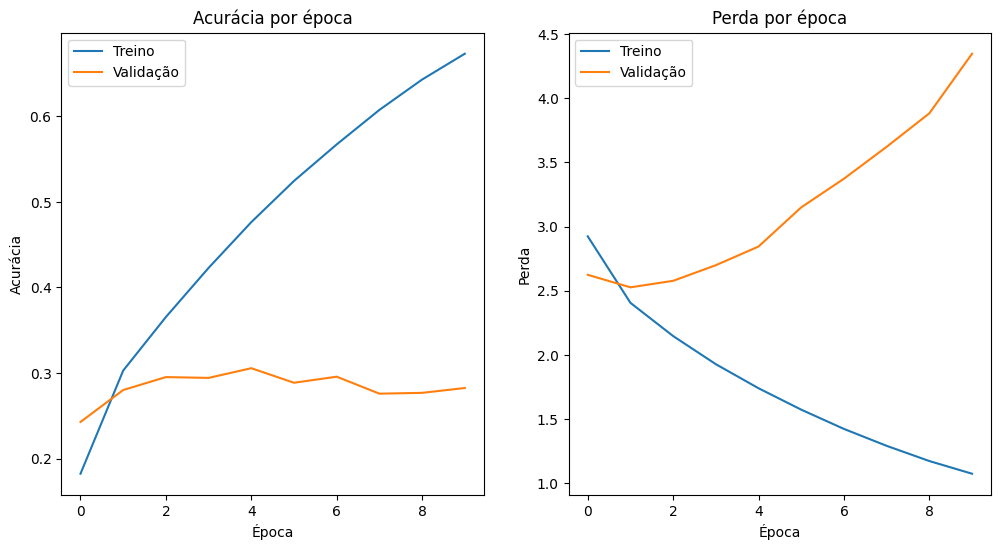

In [25]:
view_history(history_time_domain)

Pelos resultados do modelo anterior, é possível observar que o modelo não desempenhou tão bem no domínio do tempo (apresentou Overfitting), iremos tentar a seguir no domínio da **frequência**, onde ao invés de passarmos a rede neural um espectro, iremos passar um **espectrograma**.

## Domínio da Frequência

### Aplicando a FFT (Transformada Rápida de Fourier - Fast Fourier Transform) em sinais de áudio

Para passarmos um dado que está no domínio do tempo para o domínio da frequência utilizamos uma **Transformada de Fourier**

Um Espectrograma é uma representação visual que mostra como o espectro de frequências de um sinal varia com o tempo. O eixo horizontal representa o tempo e o eixo vertical representa a frequência, e a intensidade (amplitude) de cada ponto é indicada por uma escala de cores ou níveis de cinza.

Porém, diferentemente da transformada simples, o método que utilizaremos pegará cortes da nossa forma de onda e irá passar cada um desses cortes para o domínio da frequência, porém sem perder o domínio do tempo (algo que na fft simples acontece).

Parâmetros
- *frame_length*: Tamanho do comprimento da janela que irá ser utilizado para fazer os cortes.
- *frame_step*: De quanto em quanto irá "andar" fazendo cortes da nossa forma de onda (áudio).

**Complemento:**

Essa transformação é especialmente poderosa porque torna possível analisar as características espectrais de sinais de áudio. Ao converter sinais de áudio para o domínio da frequência, a FFT permite que algoritmos de deep learning captem padrões que seriam difíceis de detectar no domínio do tempo, melhorando significativamente a precisão em tarefas como classificação de sons, reconhecimento de voz e identificação de eventos sonoros.

In [26]:
def generate_spectrogram(wave):
    # Adiciona 3 dimensões para ser uma representação visual (imagem) e mantendo a dimensão de tempo
    espect = tf.signal.stft(wave, frame_length=255, frame_step=128)
    espect = tf.abs(espect) # Adquire valor absoluto, pois o resultado do stft são números complexos, para pegar apenas a amplitude
    
    espect = espect[..., tf.newaxis]
    return espect

Acima é utilizado a STFT (Transformada de Fourier de Curto Prazo), que resolve a limitação da perda de informação temporal ao aplicar a FFT, onde não é possível saber quando as frequências ocorrem ao longo do tempo. Para resolver essa limitação, a STFT divide o sinal em janelas temporais antes de aplicar a FFT a cada uma dessas janelas. Em vez de analisar o sinal inteiro de uma só vez, a STFT permite examinar como as frequências mudam ao longo do tempo, proporcionando uma visão mais detalhada e dinâmica do sinal. 

Oferece um equilíbrio entre informações de tempo e frequência, algo que é crucial em tarefas como classificação de áudio, onde o contexto temporal das frequências é tão importante quanto as frequências em si.

In [27]:
espectrograma = generate_spectrogram(audio.numpy())

In [28]:
def plot_spectrogram(spectrogram):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    
    plt.pcolormesh(X, Y, log_spec)

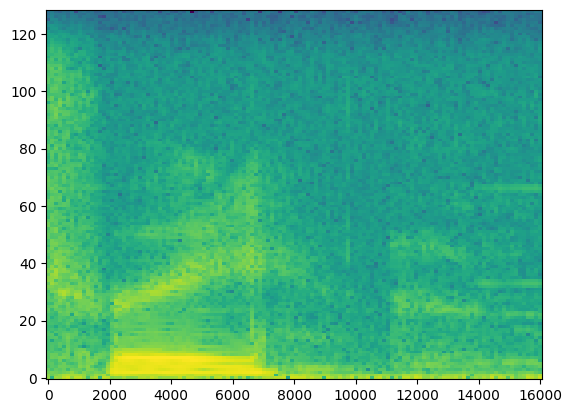

In [29]:
plot_spectrogram(espectrograma)

### Reprocessando os dados

In [30]:
def get_spectrogram_and_label(audio, label):
    espect = generate_spectrogram(audio)
    return espect, label

Uma explicação sobre a função Map (nativa) do Python:

[Como usar a função Map do Python](https://www.digitalocean.com/community/tutorials/how-to-use-the-python-map-function-pt)

In [31]:
train_spec = train_dataset.map(map_func=get_spectrogram_and_label, num_parallel_calls=tf.data.AUTOTUNE)
val_spec = val_dataset.map(map_func=get_spectrogram_and_label, num_parallel_calls=tf.data.AUTOTUNE)

**Normalização dos dados entre 0 e 1**

In [38]:
norm_layer = layers.Normalization()

# Percorre os espectrogramas e normaliza os valores
for spectrogram, _ in train_spec.take(1):
    norm_layer.adapt(spectrogram)
    input_shape = spectrogram.shape[1:] # Pega a partir do 1 índice

2025-05-10 20:51:11.936238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:8: Filling up shuffle buffer (this may take a while): 985 of 1000
2025-05-10 20:51:11.943068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


In [39]:
input_shape

TensorShape([124, 129, 1])

### Adaptando a rede para Espectrogramas com Conv2D

In [44]:
model_spectrogram = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32,32), # Redimensiona as imagens para 32x32 pixels
    
    norm_layer, # Camada de normalização dos dados
    
    layers.Conv2D(32, 3, activation='relu'), # Camada convolucional com 32 filtros de 3x3 pixels
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25), # Evitar o overfitting
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(len(unique_labels), activation='softmax')
])

In [45]:
model_spectrogram.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

In [46]:
history_spectrogram = model_spectrogram.fit(train_spec,
                                            epochs=10,
                                            validation_data=val_spec)

Epoch 1/10


I0000 00:00:1746922386.997688    1011 service.cc:152] XLA service 0x7f90e4005100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746922386.997730    1011 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2025-05-10 21:13:07.144044: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746922454.230858    1011 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-05-10 21:13:08.217781: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.6 = (f32[32,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,32,32]{3,2,1,0} %bitcast.7070, f32[32,1,3,3]{3,2,1,0} %bitcast.7077, f32[32]{0} %bitcast.7512), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$c

  12/3242 ━━━━━━━━━━━━━━━━━━━━ 48s 15ms/step - accuracy: 0.0526 - loss: 3.6099

I0000 00:00:1746922390.470883    1011 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3204/3242 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.3379 - loss: 2.3810

2025-05-10 21:16:08.953634: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.7 = (f32[6,64,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,32,30,30]{3,2,1,0} %bitcast.7574, f32[64,32,3,3]{3,2,1,0} %bitcast.7095, f32[64]{0} %bitcast.7634), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/conv2d_5_1/convolution" source_file="/home/wolf/anaconda3/envs/ai_env/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-10 21:16:11.815228: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: me

3242/3242 ━━━━━━━━━━━━━━━━━━━━ 188s 56ms/step - accuracy: 0.3395 - loss: 2.3745 - val_accuracy: 0.7359 - val_loss: 0.9377
Epoch 2/10
2982/3242 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.6396 - loss: 1.2272

2025-05-10 21:18:24.623365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 70 of 1000
2025-05-10 21:17:18.233559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


3242/3242 ━━━━━━━━━━━━━━━━━━━━ 66s 20ms/step - accuracy: 0.6409 - loss: 1.2222 - val_accuracy: 0.7761 - val_loss: 0.7735
Epoch 3/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 65s 20ms/step - accuracy: 0.6957 - loss: 1.0168 - val_accuracy: 0.7978 - val_loss: 0.6646
Epoch 4/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 87s 27ms/step - accuracy: 0.7262 - loss: 0.9063 - val_accuracy: 0.8144 - val_loss: 0.6270
Epoch 5/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 150s 46ms/step - accuracy: 0.7500 - loss: 0.8222 - val_accuracy: 0.8248 - val_loss: 0.5860
Epoch 6/10
3136/3242 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.7674 - loss: 0.7676

2025-05-10 21:25:50.301409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 853 of 1000
2025-05-10 21:25:50.364244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


3242/3242 ━━━━━━━━━━━━━━━━━━━━ 143s 44ms/step - accuracy: 0.7675 - loss: 0.7674 - val_accuracy: 0.8328 - val_loss: 0.5518
Epoch 7/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 102s 31ms/step - accuracy: 0.7810 - loss: 0.7268 - val_accuracy: 0.8295 - val_loss: 0.5500
Epoch 8/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 65s 20ms/step - accuracy: 0.7893 - loss: 0.6882 - val_accuracy: 0.8356 - val_loss: 0.5267
Epoch 9/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 161s 50ms/step - accuracy: 0.8007 - loss: 0.6522 - val_accuracy: 0.8361 - val_loss: 0.5227
Epoch 10/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 140s 43ms/step - accuracy: 0.8048 - loss: 0.6349 - val_accuracy: 0.8493 - val_loss: 0.4909


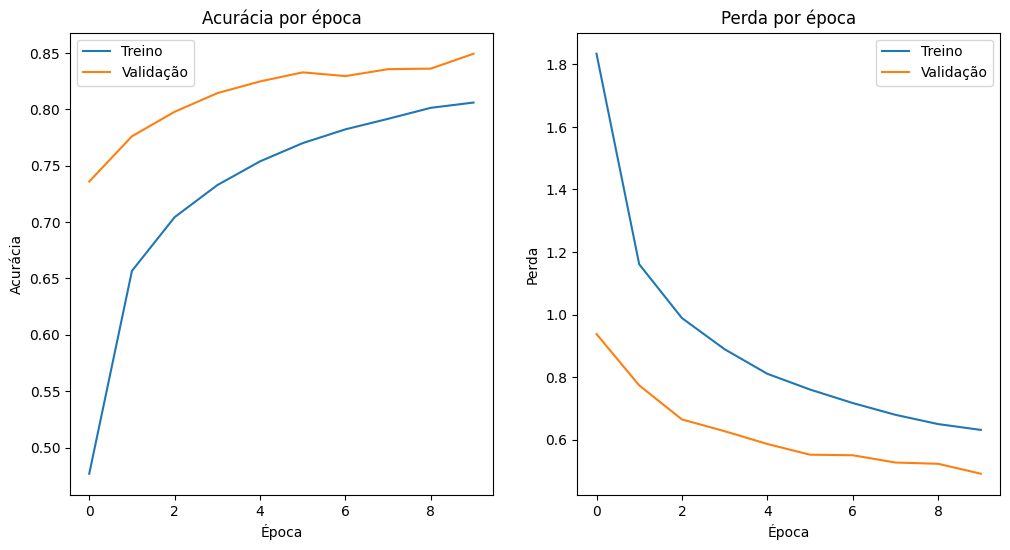

In [49]:
view_history(history_spectrogram)

### Implementando uma camada de atenção de canal

Nessa camada de atenção, iremos implementar **camadas de pooling**, onde irão ajudar o modelo se **atentar em determinadas partes dos nossos dados que são mais importantes** para a identificação de características que irão ajudar o modelo a classificar a qual classe pertence um som específico.

A camada de atenção melhora o desempenho do modelo ao destacar as partes mais relevantes dos espectrogramas, o que pode levar a uma melhor precisão na tarefa de classificação.

**Entendendo mais o funcionamento de um mecanismo de atenção de canal**

A atenção de canal é um mecanismo que permite a uma rede neural focar em canais de características mais relevantes, ignorando informações menos importantes. Esse teipo de atenção é particularmente útil em tarefas de classificação de áudio, imagens ou qualquer outra tarefa onde diferentes canais (por exemplo, frequências de som ou características de imagem) contribuem de forma variável para a decisão final.

Essa abordagem também ajuda a reduzir o *overfitting*, pois a rede aprende a ignorar ruídos irrelevantes nos dados de entrada.

In [115]:
class ChannelAttention(layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        self.avg_pool = layers.GlobalAveragePooling2D() # Reduz a dimensionalidade, é uma camada que é utilizada após as camadas convolucionais
        self.max_pool = layers.GlobalMaxPooling2D()   
        
    def build(self, input_shape):
        # Camada densa de rede neural regulado pelo ratio
        self.fc1 = layers.Dense(units=input_shape[-1]//self.ratio, activation='relu')
        self.fc2 = layers.Dense(units=input_shape[-1], activation='sigmoid')
        
    def call(self, inputs):
        avg_out = self.avg_pool(inputs)
        max_out = self.max_pool(inputs)
        
        avg_out = self.fc2(self.fc1(avg_out))
        max_out = self.fc2(self.fc1(max_out))
        
        out = avg_out + max_out
        out = tf.expand_dims(tf.expand_dims(out, axis=1), axis=1)
        
        return inputs * out

**Adicionando a camada de canal de atenção na arquitetura da rede neural**

In [116]:
model_spectrogram_attention = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32,32),
    
    norm_layer,
    
    layers.Conv2D(32, 3, activation='relu'),
    ChannelAttention(ratio=8),
    
    layers.Conv2D(64, 3, activation='relu'),
    ChannelAttention(ratio=8),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(len(unique_labels), activation='softmax')
])

In [117]:
model_spectrogram_attention.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

In [119]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [ModelCheckpoint('audio_model.keras', 'val_loss', save_best_only=True)]

In [120]:
history_spectrogram_attention = model_spectrogram_attention.fit(train_spec,
                                            epochs=10,
                                            validation_data=val_spec,
                                            callbacks=callbacks)

Epoch 1/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 75s 23ms/step - accuracy: 0.5996 - loss: 1.3560 - val_accuracy: 0.7780 - val_loss: 0.7919
Epoch 2/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - accuracy: 0.6888 - loss: 1.0496 - val_accuracy: 0.8153 - val_loss: 0.6466
Epoch 3/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - accuracy: 0.7300 - loss: 0.8996 - val_accuracy: 0.8238 - val_loss: 0.5794
Epoch 4/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 92s 28ms/step - accuracy: 0.7550 - loss: 0.8077 - val_accuracy: 0.8337 - val_loss: 0.5555
Epoch 5/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 69s 21ms/step - accuracy: 0.7740 - loss: 0.7383 - val_accuracy: 0.8337 - val_loss: 0.5215
Epoch 6/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 82s 25ms/step - accuracy: 0.7896 - loss: 0.6839 - val_accuracy: 0.8488 - val_loss: 0.5001
Epoch 7/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - accuracy: 0.8010 - loss: 0.6432 - val_accuracy: 0.8578 - val_loss: 0.4855
Epoch 8/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 72s 22ms/step - accuracy: 0.8113 -

2025-05-10 23:16:07.525508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:11: Filling up shuffle buffer (this may take a while): 865 of 1000
2025-05-10 23:16:07.579344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


3242/3242 ━━━━━━━━━━━━━━━━━━━━ 85s 26ms/step - accuracy: 0.8234 - loss: 0.5663 - val_accuracy: 0.8611 - val_loss: 0.4649


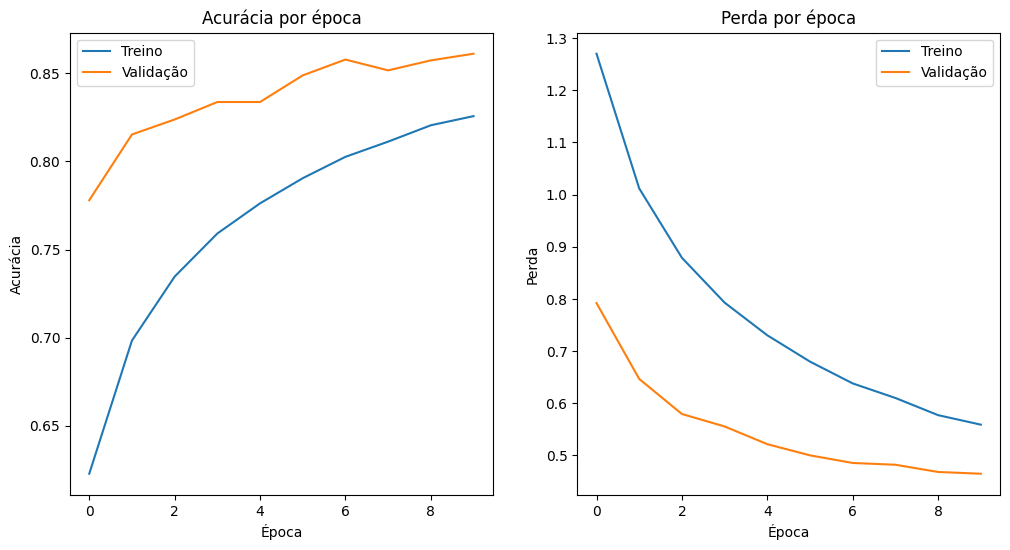

In [121]:
view_history(history_spectrogram_attention)